# Coffea-Casa Benchmark Example 3

In [1]:
import numpy as np
%matplotlib inline
import hist
import coffea.processor as processor
import awkward as ak
from coffea.nanoevents import schemas

In [2]:
# This program plots a per-event array (jet_pt) that has been masked to meet certain conditions (in this case, abs(jet eta) < 1).

class Processor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.axis.StrCategory(name="dataset", label="", categories=[], growth=True)
        Jet_axis = hist.axis.Regular(name="Jet_pt", label="Jet_pt [GeV]", bins=50, start=15, stop=60)
        
        self.output = processor.dict_accumulator({
            'Jet_pt': hist.Hist(dataset_axis, Jet_axis),
            'cutflow': processor.defaultdict_accumulator(int)
        })
        
    def process(self, events):
        dataset = events.metadata['dataset']
        jets = events.Jet

        self.output['cutflow']['all events'] += ak.size(jets, axis=0)
        self.output['cutflow']['number of jets'] += ak.sum(ak.num(jets))
        
        # We want jets with an abs(eta) < 1. Conditionals act on every value in an array in Coffea, so this is easy.
        eta_max = (np.absolute(jets.eta) < 1)
        # eta_max is a Boolean array, with True in the place of values where the condition is met, and False otherwise. We want to sum up all the Trues (=1) in each sublist, then sum up all the sublists to get the number of jets with pt > 20.
        self.output['cutflow']['abs(eta) < 1'] += ak.sum(ak.sum(eta_max, axis=1))
            
        # We define good_jets as the actual jets we want to graph. We mask it with the jets that have abs(eta) < 1.
        good_jets = jets[eta_max]
        # good_jets is no longer a Boolean array, so we can't just sum up the True's. We count the amount of jets and sum that.
        self.output['cutflow']['final good jets'] += ak.sum(ak.num(good_jets, axis=1))
        
        self.output['Jet_pt'].fill(dataset=dataset, Jet_pt=ak.flatten(good_jets.pt))
        return self.output

    def postprocess(self, accumulator):
        pass

In [3]:
from dask.distributed import Client

client = Client("tls://localhost:8786")

In [4]:
fileset = {'SingleMu' : ["root://eospublic.cern.ch//eos/root-eos/benchmark/Run2012B_SingleMu.root"]}

executor = processor.DaskExecutor(client=client)

run = processor.Runner(executor=executor,
                        schema=schemas.NanoAODSchema,
                        savemetrics=True
                      )

output, metrics = run(fileset, "Events", processor_instance=Processor())

metrics

{'bytesread': 2727541868,
 'columns': ['nJet', 'Jet_pt', 'Jet_eta'],
 'entries': 53446198,
 'processtime': 994.5796327590942,
 'chunks': 534}

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f6d6428eee0>, errorbar=None, legend_artist=None)]

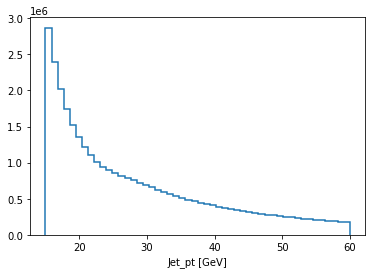

In [5]:
output['Jet_pt'].plot1d()

In [6]:
for key, value in output['cutflow'].items():
    print(key, value)

all events 53446198
number of jets 170952895
abs(eta) < 1 39563735
final good jets 39563735
